#Deep Learning - Project

*Irland news headlines data*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import regex
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WordPunctTokenizer
from string import punctuation
import plotly.express as px
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer

# https://www.kaggle.com/code/darkrubiks/classifying-irish-times-headlines-categories#Predicting-the-Headlines-Categories

In [ ]:
pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.7/211.7 kB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=925ded3feaf600b7f2c0098f276945247f8fc4fb297c757fa66470819e733474
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
!wandb login 560f9a0bec740190078e4e73f98beb208a0f6c18

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

# simulate training
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset

    # log metrics to wandb
    wandb.log({"acc": acc, "loss": loss})

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

wandb: Currently logged in as: yazansh1 (team-04). Use `wandb login --relogin` to force relogin


acc,▁▇▅██▇▇█
loss,█▃▄▃▁▁▁▁
acc,0.87052
loss,0.10685


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Untitled folder/ireland-news-headlines.csv"

'/content/drive/MyDrive/Untitled folder/ireland-news-headlines.csv'


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Untitled folder/ireland-news-headlines.csv')
data

,publish_date,headline_category,headline_text
0,19960102,news,UUP sees possibility of voting Major out
1,19960102,news,Pubs targeted as curbs on smoking are extended
2,19960102,news,Papers reveal secret links with O'Neill cabinet
3,19960102,news,Domestic chaos as Italy takes EU presidency
4,19960102,news,Learning about the star to which we owe life
...,...,...,...
1611490,20210630,news.politics.oireachtas,Reserve members of Defence Forces to be allowe...
1611491,20210630,culture,Maureen Dowd: Joe Biden is 'crazy about the Ir...
1611492,20210630,sport.others,Andy Murray rolls back the years to own Centre...
1611493,20210630,news.health,Delta variant could do 'significant damage' in...


### Importing the data

## Data Exploration

In [ ]:
data.shape

(1611495, 3)

In [ ]:
data.isna().sum()
#We can see that we have 7 nulls in the headline text, we will remove them

publish_date         0
headline_category    0
headline_text        7
dtype: int64

In [ ]:
#removing the missing text articles
data = data.dropna()
data.isna().sum()

publish_date         0
headline_category    0
headline_text        0
dtype: int64

In [ ]:
data.duplicated().sum()
#Check what to do with it###

0

In [ ]:
#Checking how many istanses we have of each category over the years in the data set
data["headline_category"].value_counts()

news                               580238
sport                              158682
business                           111435
opinion.letters                     79276
opinion                             49946
                                    ...  
lifestyle.food.restaurant             203
news.technology                       191
business.markets.bonds                127
lifestyle.abroad.working-abroad       116
news.health.coronavirus               104
Name: headline_category, Length: 103, dtype: int64

### Data Pre-Processing

In [ ]:
#Date modifications
#We will change the publish date to date time format
#We will add month and day date for further analyzing
data.loc[:, 'publish_date'] = pd.to_datetime(data['publish_date'], format='%Y%m%d')
data.loc[:, 'month'] = data['publish_date'].dt.month
data.loc[:, 'day'] = data['publish_date'].dt.day
data

<ipython-input-13-fefd81920beb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'publish_date'] = pd.to_datetime(data['publish_date'], format='%Y%m%d')
<ipython-input-13-fefd81920beb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'month'] = data['publish_date'].dt.month
<ipython-input-13-fefd81920beb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

,publish_date,headline_category,headline_text,month,day
0,1996-01-02,news,UUP sees possibility of voting Major out,1,2
1,1996-01-02,news,Pubs targeted as curbs on smoking are extended,1,2
2,1996-01-02,news,Papers reveal secret links with O'Neill cabinet,1,2
3,1996-01-02,news,Domestic chaos as Italy takes EU presidency,1,2
4,1996-01-02,news,Learning about the star to which we owe life,1,2
...,...,...,...,...,...
1611490,2021-06-30,news.politics.oireachtas,Reserve members of Defence Forces to be allowe...,6,30
1611491,2021-06-30,culture,Maureen Dowd: Joe Biden is 'crazy about the Ir...,6,30
1611492,2021-06-30,sport.others,Andy Murray rolls back the years to own Centre...,6,30
1611493,2021-06-30,news.health,Delta variant could do 'significant damage' in...,6,30


In [ ]:
# Unifing sub-categories into main categories by first delimter of "."
def split_point(x):
  split = x.split(".")
  x = split[0]
  return x

data["headline_category"] = data["headline_category"].apply(split_point)
data["headline_category"].value_counts()
#we are left with 6 main categories news : sport, business, opinion ,culture, lifestyle

<ipython-input-14-ba7783f4edc2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["headline_category"] = data["headline_category"].apply(split_point)


news         798680
sport        261826
business     222960
opinion      133073
culture       98944
lifestyle     96005
Name: headline_category, dtype: int64

# We Can see that there are almost 800K rows of news which cause over fittting and imbalanced data.
# So we decided to balance our data by deleting X rows from News category and adding Y rows to culture, opinion, lifestyle...

In [ ]:
news_delete = data[data["headline_category"]=="news"].sample(n=702680).index
data = data.drop(news_delete)
data["headline_category"].value_counts()

sport        261826
business     222960
opinion      133073
culture       98944
lifestyle     96005
news          96000
Name: headline_category, dtype: int64

In [ ]:
#news_delete = data[data["headline_category"]=="news"].sample(n=520000).index
#data = data.drop(news_delete)
#data["headline_category"].value_counts()

In [ ]:
news_delete = data[data["headline_category"]=="sport"].sample(n=165826).index
data = data.drop(news_delete)
data["headline_category"].value_counts()


business     222960
opinion      133073
culture       98944
lifestyle     96005
news          96000
sport         96000
Name: headline_category, dtype: int64

In [ ]:
news_delete = data[data["headline_category"]=="business"].sample(n=126960).index
data = data.drop(news_delete)
data["headline_category"].value_counts()


opinion      133073
culture       98944
lifestyle     96005
news          96000
business      96000
sport         96000
Name: headline_category, dtype: int64

In [ ]:
news_delete = data[data["headline_category"]=="culture"].sample(n=2944).index
data = data.drop(news_delete)
data["headline_category"].value_counts()


opinion      133073
lifestyle     96005
news          96000
culture       96000
business      96000
sport         96000
Name: headline_category, dtype: int64

In [ ]:
news_delete = data[data["headline_category"]=="opinion"].sample(n=37073).index
data = data.drop(news_delete)
data["headline_category"].value_counts()

lifestyle    96005
news         96000
culture      96000
opinion      96000
business     96000
sport        96000
Name: headline_category, dtype: int64

In [ ]:
data

,publish_date,headline_category,headline_text,month,day
5,1996-01-02,news,EU proposal for 'skills cards' to detail educa...,1,2
13,1996-01-02,news,Funeral told McCrory killing 'sullied city',1,2
14,1996-01-02,news,Haughey refuses comment on passport deal,1,2
17,1996-01-02,news,Gardai issue appeal as hunt for woman continues,1,2
23,1996-01-02,news,RTE's plan on North reception,1,2
...,...,...,...,...,...
1611477,2021-06-30,sport,Nuno Espírito Santo confirmed as new Spurs boss,6,30
1611480,2021-06-30,sport,Flexible England win battle for midfield in co...,6,30
1611485,2021-06-30,business,Gap to close all Irish and UK stores by end of...,6,30
1611491,2021-06-30,culture,Maureen Dowd: Joe Biden is 'crazy about the Ir...,6,30


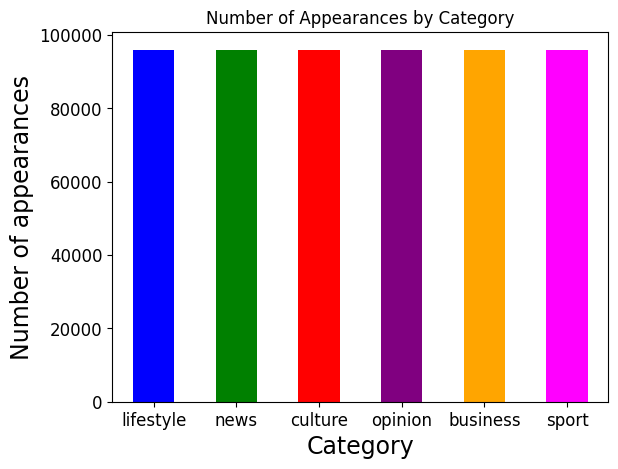

In [ ]:
# Plotting a bar chart to see the overall appearancses of each category after the unfigying we made
counts = data['headline_category'].value_counts()

# color map for the bars
colors = ['blue', 'green', 'red', 'purple', 'orange','magenta']

# plot the result using a bar chart with custom colors
counts.plot.bar(color=colors[:len(counts)])

# set plot title and axis labels
plt.title('Number of Appearances by Category')
plt.xlabel('Category', fontsize=17)
plt.ylabel('Number of appearances', fontsize=17)
#plt.xticks(rotation=0)

# set x-axis tick labels font size
plt.xticks(rotation=0, fontsize=12)  # Adjust the fontsize parameter to your desired size
plt.yticks(rotation=0, fontsize=12)  # Adjust the fontsize parameter to your desired size


# show the plot
plt.show()

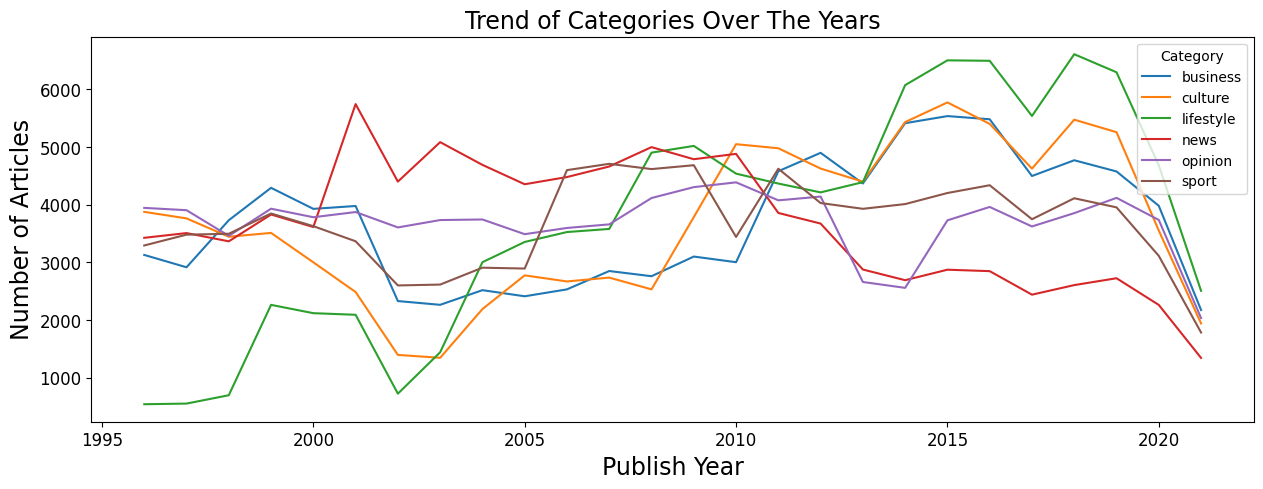

In [ ]:
#Plotting a trend graph over the years of publish dates to see categories volume trend

grouped_data = data.groupby([data['publish_date'].dt.year, 'headline_category']).size().unstack()

# Plot the data
grouped_data.plot(kind='line', figsize=(15, 5))
plt.xlabel('Publish Year', fontsize=17)
plt.ylabel('Number of Articles' ,fontsize=17)
plt.title('Trend of Categories Over The Years',fontsize=17)
plt.legend(title='Category', loc = "upper right")
plt.xticks(rotation=0, fontsize=12)  # Adjust the fontsize parameter to your desired size
plt.yticks(rotation=0, fontsize=12)  # Adjust the fontsize parameter to your desired size
plt.show()

#We can see that news articles are the most common over the years by far. also can see a big decrease in the volumne of the articles from 2010 in all categories


In [ ]:
#Plotting a trend graph over the years of publish dates to see categories volume trend
data_avg = data
data_avg["num"] = 1
data.set_index("month")
grouped_data = data_avg.groupby(["month", "headline_category"])["num"].mean()
grouped_data

month  headline_category
1      business             1.0
       culture              1.0
       lifestyle            1.0
       news                 1.0
       opinion              1.0
                           ... 
12     culture              1.0
       lifestyle            1.0
       news                 1.0
       opinion              1.0
       sport                1.0
Name: num, Length: 72, dtype: float64

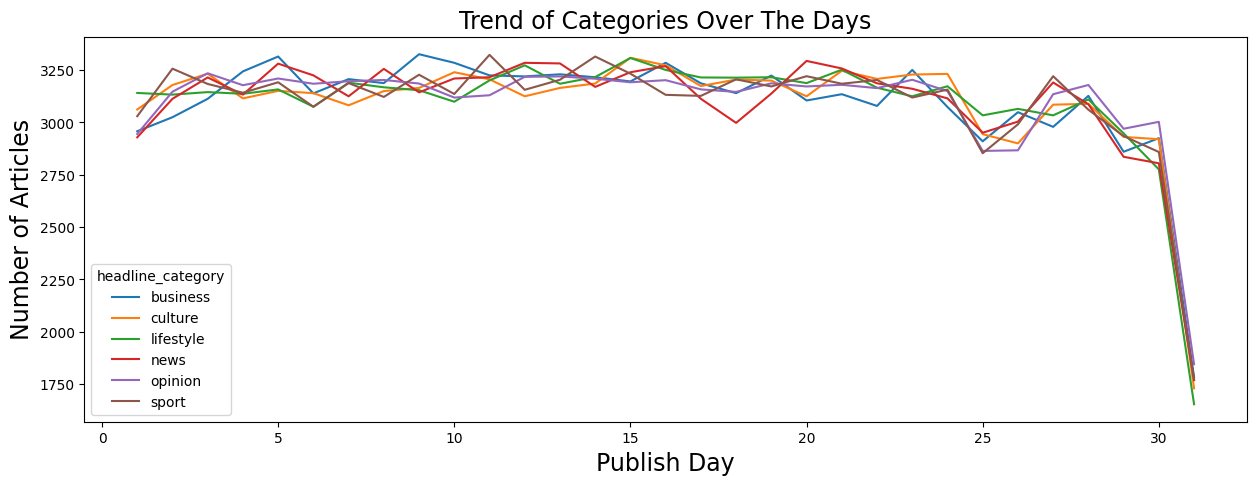

In [ ]:
#Plotting a trend graph over the years of publish dates to see categories volume trend

grouped_data = data.groupby([data['day'], 'headline_category']).size().unstack()

# Plot the data
grouped_data.plot(kind='line', figsize=(15, 5))
plt.xlabel('Publish Day',fontsize=17)
plt.ylabel('Number of Articles',fontsize=17)
plt.title('Trend of Categories Over The Days',fontsize=17)
#plt.legend(title='Category', loc = "upper right",fontsize=17)

plt.show()

#We can see that news articles are the most common over the years by far. also can see a big decrease in the volumne of the articles from 2010 in all categories


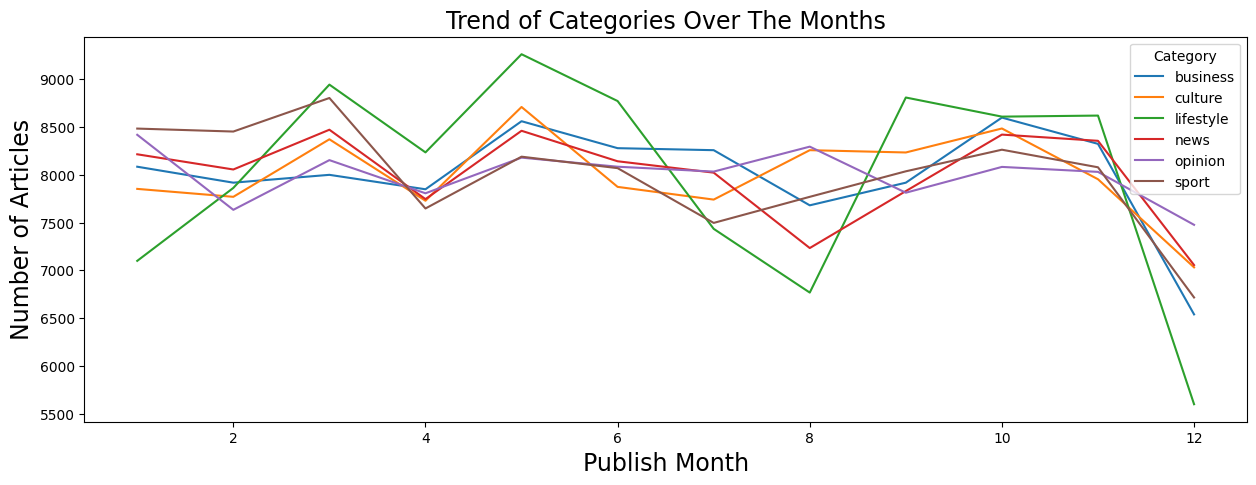

<Figure size 2000x480 with 0 Axes>

<Figure size 640x2000 with 0 Axes>

In [ ]:
#Plotting a trend graph over the years of publish dates to see categories volume trend

grouped_data = data.groupby([data['month'], 'headline_category']).size().unstack()

# Plot the data
grouped_data.plot(kind='line', figsize=(15, 5))
plt.xlabel('Publish Month', fontsize=17)
plt.ylabel('Number of Articles',fontsize=17)
plt.title('Trend of Categories Over The Months',fontsize=17)
plt.legend(title='Category', loc = "upper right")
plt.show()

plt.figure().set_figwidth(20)
plt.figure().set_figheight(20)
#plt.tick_params(axis='both', which='major', labelsize=12)

#We can see that news articles are the most common over the years by far. also can see a big decrease in the volumne of the articles from 2010 in all categories

In [ ]:
# Removing stop words using the WordNetLemmatizer library

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

wordnet = WordNetLemmatizer()
stop_words = stopwords.words('english')

for punct in punctuation:
    stop_words.append(punct)

def filter_text(text, stop_words):
    if isinstance(text, str):
        word_tokens = WordPunctTokenizer().tokenize(text.lower())
        filtered_text = [regex.sub(u'\p{^Latin}', u'', w) for w in word_tokens if w.isalpha()]
        filtered_text = [wordnet.lemmatize(w, pos="v") for w in filtered_text if not w in stop_words]
        return " ".join(filtered_text)
    else:
        return ""
data['headline_text'] = data['headline_text'].apply(lambda x: filter_text(x, stop_words))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def words_frequency(x):
  data_category = data[data["headline_category"] == x]
  data_words_category = data_category["headline_text"].str.split(expand=True).stack().value_counts()
  data_words_category = pd.DataFrame(data_words_category)
  data_words_category = data_words_category.rename(columns={ 0: "count"})
  data_words_category = data_words_category.reset_index()
  data_words_category = data_words_category.rename(columns={ "index": "words"}, errors="raise")
  fig = px.treemap(data_words_category[0:100], path=[px.Constant(x +" Words Frequency"), 'words'],
                  values='count',
                  color='count',
                  color_continuous_scale='viridis',
                  color_continuous_midpoint=np.average(data_words_category['count'])
                  )
  fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
  fig.show()

x='news'
words_frequency(x)

In [ ]:
list1 = ['business','sport','culture','opinion','lifestyle']
for i in list1:
  words_frequency(i)

In [ ]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.1 MB/s eta 0:00:00


In [ ]:
pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.6 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=a095ec2a8bf713d165c932c78c34bbbae9f72aeaf0a05eda048834b9489c1e3b
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
pip install cosine_similarity

### The semantic textual similarity (STS) problem attempts to compare two texts and decide whether they are similar in meaning.

In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import random

tqdm.pandas()
nlp = spacy.load("en_core_web_sm")

data1 = data

def text_processing(sentences):
    processed_sentences = []
    for sentence in sentences:
        processed_sentence = [token.lemma_.lower()
                              for token in nlp(sentence)
                              if token.is_alpha and not token.is_stop]
        processed_sentences.append(processed_sentence)
    return processed_sentences

def cos_sim(sentence1_emb, sentence2_emb, sentences):
    cos_sim_matrix = cosine_similarity(sentence1_emb, sentence2_emb)

    high_similarities = []
    medium_similarities = []
    low_similarities = []

    for i in range(len(sentences)):
        for j in range(i+1, len(sentences)):
            similarity = cos_sim_matrix[i, j]

            if similarity >= 0.8 and len(high_similarities) < 100:
                high_similarities.append((sentences[i], sentences[j], similarity))


            if len(high_similarities) >= 100:
                break

        if len(high_similarities) >= 100:
            break

    all_similarities = high_similarities + medium_similarities + low_similarities
    random.shuffle(all_similarities)

    unique_similarities = []
    seen_sentences = set()

    for s1, s2, similarity in all_similarities:
        if s1 not in seen_sentences and s2 not in seen_sentences:
            unique_similarities.append((s1, s2, similarity))
            seen_sentences.add(s1)
            seen_sentences.add(s2)
            if len(unique_similarities) >= 50:
                break

    count = 0
    for s1, s2, similarity in unique_similarities:
        print(f"Similarity between '{s1}' and '{s2}': {similarity:.4f}")
        count += 1
        if count >= 50:
            break

    print(unique_similarities)
    print(len(unique_similarities))

from sentence_transformers import SentenceTransformer

# Load the pre-trained model
model = SentenceTransformer('stsb-mpnet-base-v2')

# Get a random sample of headlines from the dataset but only from 'business' category
random_headlines = data1[data1['headline_category'] == 'culture']['headline_text'].sample(n=10000, replace=False).tolist()

# Process headlines
processed_headlines = text_processing(random_headlines)

# Filter out sentences with less than 4 words
filtered_headlines = [sentence for sentence in processed_headlines if len(sentence) >= 4]

# Randomly select the first sentence from the dataset for each line
random_first_sentences = random.sample(data1['headline_text'].tolist(), len(filtered_headlines))

# Convert processed headlines into sentences (list of strings)
sentences = [' '.join(tokens) for tokens in filtered_headlines]

# Generate embeddings
headline_emb = model.encode(sentences, show_progress_bar=True)

# Calculate similarity
cos_sim(headline_emb, headline_emb, sentences)

Batches:   0%|          | 0/175 [00:00<?, ?it/s]

Similarity between 'good film cinema weekend' and 'good film cinemas weekend': 0.9591
Similarity between 'film cinema week review rat' and 'late movie review film cinemas week rat': 0.8252
Similarity between 'donald clarke weekly movie quiz' and 'donald clarke weekly movie quiz': 1.0000
Similarity between 'electric picnic act catch saturday' and 'electric picnic thing festival saturday': 0.8409
Similarity between 'leonard cohen obituary revere poet novelist musician' and 'old friend poem leonard cohen': 0.8220
Similarity between 'good traditional music gig week' and 'week good traditional music concert event': 0.8998
Similarity between 'irish time journalist launch debut children book' and 'irish time review new book young reader': 0.8191
Similarity between 'tv guide good watch week' and 'tv guide good watch week': 1.0000
Similarity between 'ag ceiliúradh fhile tháinig ar saol bliain ó shin' and 'seilide tháinig slán fabhalscéal ár linne': 0.8052
Similarity between 'new film stream wee

In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import random

tqdm.pandas()
nlp = spacy.load("en_core_web_sm")

data1 = data

def text_processing(sentences):
    processed_sentences = []
    for sentence in sentences:
        processed_sentence = [token.lemma_.lower()
                              for token in nlp(sentence)
                              if token.is_alpha and not token.is_stop]
        processed_sentences.append(processed_sentence)
    return processed_sentences

def cos_sim(sentence1_emb, sentence2_emb, sentences):
    cos_sim_matrix = cosine_similarity(sentence1_emb, sentence2_emb)

    high_similarities = []
    medium_similarities = []
    low_similarities = []

    for i in range(len(sentences)):
        for j in range(i+1, len(sentences)):
            similarity = cos_sim_matrix[i, j]

            if similarity >= 0.8 and len(high_similarities) < 100:
                high_similarities.append((sentences[i], sentences[j], similarity))
            elif similarity >= 0.7 and len(medium_similarities) < 100:
                medium_similarities.append((sentences[i], sentences[j], similarity))
            elif similarity < 0.7 and len(low_similarities) < 100:
                low_similarities.append((sentences[i], sentences[j], similarity))

            if len(high_similarities) >= 100 and len(medium_similarities) >= 100 and len(low_similarities) >= 100:
                break

        if len(high_similarities) >= 100 and len(medium_similarities) >= 100 and len(low_similarities) >= 100:
            break

    all_similarities = high_similarities + medium_similarities + low_similarities
    random.shuffle(all_similarities)

    unique_similarities = []
    seen_sentences = set()

    for s1, s2, similarity in all_similarities:
        if s1 not in seen_sentences and s2 not in seen_sentences:
            unique_similarities.append((s1, s2, similarity))
            seen_sentences.add(s1)
            seen_sentences.add(s2)
            if len(unique_similarities) >= 50:
                break

    count = 0
    for s1, s2, similarity in unique_similarities:
        print(f"Similarity between '{s1}' and '{s2}': {similarity:.4f}")
        count += 1
        if count >= 50:
            break

    print(unique_similarities)
    print(len(unique_similarities))

from sentence_transformers import SentenceTransformer

# Load the pre-trained model
model = SentenceTransformer('stsb-mpnet-base-v2')

# Get a random sample of headlines from the dataset but only from 'business' category
random_headlines = data1[data1['headline_category'] == 'sport']['headline_text'].sample(n=10000, replace=False).tolist()

# Process headlines
processed_headlines = text_processing(random_headlines)

# Filter out sentences with less than 4 words
filtered_headlines = [sentence for sentence in processed_headlines if len(sentence) >= 4]

# Randomly select the first sentence from the dataset for each line
random_first_sentences = random.sample(data1['headline_text'].tolist(), len(filtered_headlines))

# Convert processed headlines into sentences (list of strings)
sentences = [' '.join(tokens) for tokens in filtered_headlines]

# Generate embeddings
headline_emb = model.encode(sentences, show_progress_bar=True)

# Calculate similarity
cos_sim(headline_emb, headline_emb, sentences)

Batches:   0%|          | 0/229 [00:00<?, ?it/s]

Similarity between 'driscoll heap praise gara' and 'treacy stride home retain title': 0.0971
Similarity between 'cork win goulde goal' and 'cork win team hopeful': 0.7341
Similarity between 'play south african franchise new tournament' and 'south african team eligible champion cup revamp': 0.7231
Similarity between 'handy guide sport television week' and 'handy guide sport television week': 1.0000
Similarity between 'weekend premier league team news' and 'weekend premier league team news': 1.0000
Similarity between 'fai national league preview' and 'fai national league preview': 1.0000
Similarity between 'late heroic earn ireland draw croke park' and 'kilpatrick heroics ireland final': 0.7359
Similarity between 'premier league team news' and 'premier league team news': 1.0000
Similarity between 'brian cody hail mount leinster success' and 'whelan clear play leinster': 0.7025
Similarity between 'france ireland ireland player rat' and 'limerick galway galway player rat': 0.7225
Similarit

Loading dataset:   0%|          | 0/100 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 100/100 [00:02<00:00, 39.99it/s]


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

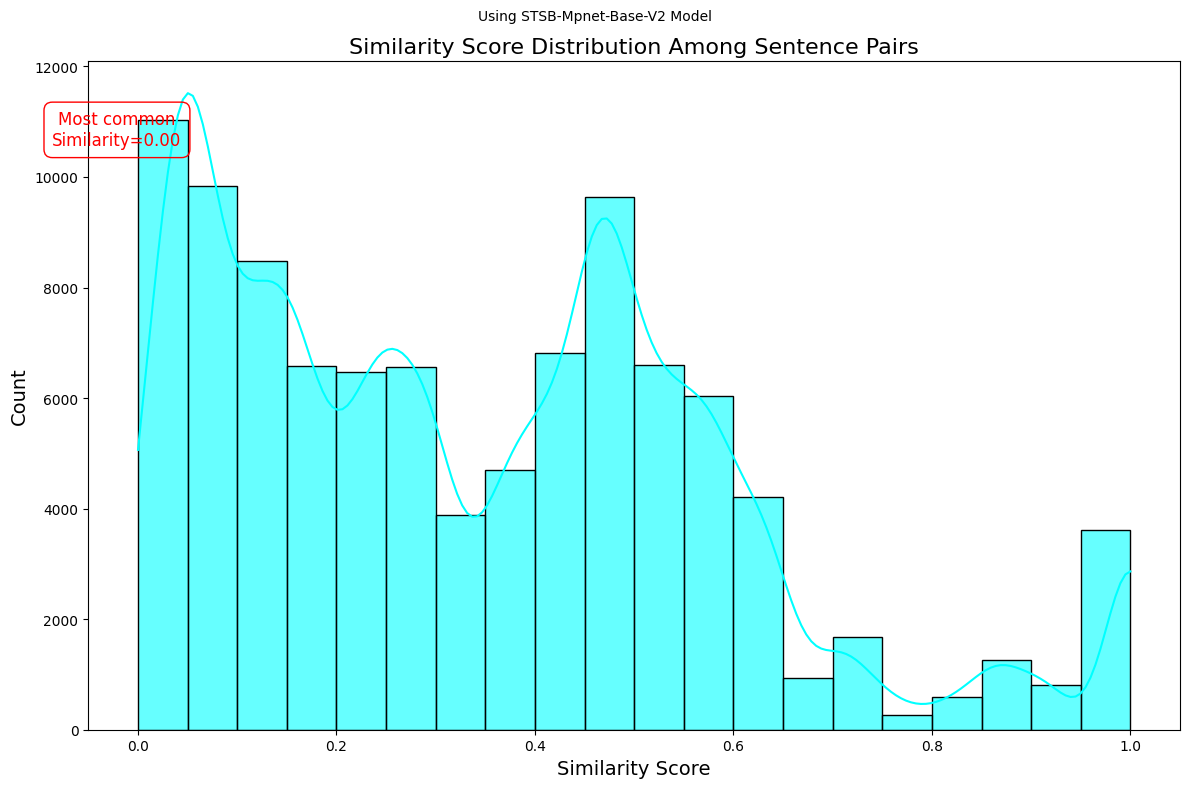

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

tqdm.pandas()
nlp = spacy.load("en_core_web_sm")

def text_processing(sentences):
    """
    Lemmatize, lowercase, remove numbers, and stop words

    Args:
        sentences: A list of sentences we want to process.

    Returns:
        A list of processed words for each sentence.
    """
    processed_sentences = []
    for sentence in sentences:
        processed_sentence = [token.lemma_.lower()
                              for token in nlp(sentence)
                              if token.is_alpha and not token.is_stop]
        processed_sentences.append(processed_sentence)

    return processed_sentences

def cos_sim(sentences):
    """
    Cosine similarity between columns of sentence embeddings

    Args:
        sentences: List of sentences
    """
    model = SentenceTransformer('stsb-mpnet-base-v2')

    # Generate embeddings
    embeddings = model.encode(sentences, show_progress_bar=True)

    # Calculate cosine similarity matrix
    cos_sim_matrix = cosine_similarity(embeddings)

    # Get upper triangular indices
    indices = np.triu_indices(len(sentences), k=1)

    # Get similarity scores
    similarities = cos_sim_matrix[indices]

    # Filter out scores larger than 0
    similarities = similarities[similarities > 0]

    # Set the maximum sample size
    max_sample_size = 100000

    # Check if the sample size is larger than the population size
    if max_sample_size > len(similarities):
        sample_size = len(similarities)
    else:
        sample_size = max_sample_size

    # Get a random sample of similarity scores
    random_scores = random.choices(similarities.tolist(), k=sample_size)

    # Plot histogram of similarity scores
    plt.figure(figsize=(12, 8))
    sns.histplot(random_scores, bins=20, kde=True, color='cyan', alpha=0.6)
    plt.xlabel('Similarity Score', fontsize=14, color='black')
    plt.ylabel('Count', fontsize=14, color='black')
    plt.title('Similarity Score Distribution Among Sentence Pairs', fontsize=16, color='black')
    plt.suptitle('Using STSB-Mpnet-Base-V2 Model', fontsize=10, color='black')

    # Get the maximum value for y and its corresponding x
    y, x, _ = plt.hist(random_scores, bins=20, range=(0, 1), alpha=0)
    max_y = max(y)
    max_x = x[np.where(y==max_y)[0][0]]

    # Add annotation
    plt.annotate(f'Most common\nSimilarity={max_x:.2f}', (max_x, max_y), textcoords="offset points", xytext=(-15,-10), ha='center', color='red', fontsize=12, bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=0.5'))

    plt.tight_layout()  # Better spacing
    plt.show()

# Load the STSB dataset
with tqdm(total=100, desc='Loading dataset') as pbar:
    stsb_dataset = load_dataset('glue', 'stsb')
    pbar.update(100)

# Access the similarity scores
similarity_scores = stsb_dataset['train']['label']

# Get a random sample of similarity scores from the dataset
random_scores = random.choices(similarity_scores, k=5000)

# Convert similarity scores into sentences (list of strings)
sentences = [str(score) for score in random_scores]

# Calculate similarity and plot histogram
cos_sim(sentences)

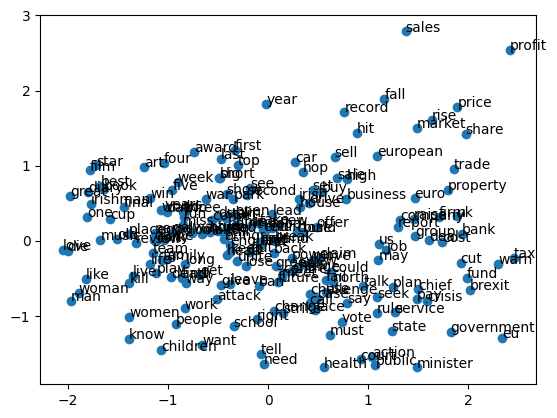

In [ ]:
# Word To Vector

# Import required libraries
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

# Load the data

# Split the headline text into words and store them as a list
sentences = [headline.split() for headline in data["headline_text"].tolist()]

# Train Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

from collections import Counter

# Count the occurrences of each word
word_counts = Counter([word for sentence in sentences for word in sentence])

# Set the minimum and maximum count thresholds for filtering words
min_count1 = 2000
max_count1 = 35000

# Filter out sentences based on word count thresholds
filtered_sentences1 = [[word for word in sentence if min_count1 <= word_counts[word] <= max_count1] for sentence in sentences]

# Train Word2Vec model on the filtered sentences
from gensim.models import Word2Vec
model1 = Word2Vec(filtered_sentences1, vector_size=100, window=3, min_count=min_count1, workers=4)

# Obtain the word vectors
X = model1.wv[model1.wv.key_to_index]

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# Plot the 2D word vector space
fig, ax = pyplot.subplots()
ax.scatter(result[:, 0], result[:, 1])

# Annotate words on the plot
words = list(model1.wv.key_to_index.keys())
for i, word in enumerate(words):
    ax.annotate(word, xy=(result[i, 0], result[i, 1]))

pyplot.show()

The Word2Vec model represents words as high-dimensional vectors, typically with several hundred dimensions. This means that each word is represented by a point in a space that has several hundred axes, with each axis representing a different aspect of the word's meaning.

However, it is difficult for us to visualize points in a space with more than three dimensions. Therefore, in order to make the word vectors more easily interpretable, we need to reduce the dimensionality of the space to two or three dimensions.

This is where PCA comes in. PCA is a mathematical technique that takes the high-dimensional word vectors and finds the two directions in the space that explain the most variation in the data. These two directions are called the principal components, and they are chosen in such a way that the first principal component captures the most variation in the data, and the second principal component captures the most variation that is orthogonal (perpendicular) to the first principal component.

So, when we plot the word vectors in the two-dimensional space defined by the two principal components, each word is represented by a point in this 2D space, with its x-coordinate corresponding to its projection onto the first principal component, and its y-coordinate corresponding to its projection onto the second principal component.

**By visualizing the word vectors in this 2D space, we can gain insights into the relationships between words based on their similarities and differences in meaning. For example, words that are semantically similar will be closer to each other in the 2D space, while words that are semantically dissimilar will be further apart.**

In [ ]:
# tokenize headlines into sentences
sentences = []
for headline in data['headline_text']:
    sentences.extend(nltk.sent_tokenize(headline))

# get lengths of each sentence
sentence_lengths = [len(nltk.word_tokenize(sentence)) for sentence in sentences]

# calculate summary statistics
mean_length = sum(sentence_lengths) / len(sentence_lengths)
std_dev = np.std(sentence_lengths)

# create histogram of sentence lengths
plt.hist(sentence_lengths, bins=10)
plt.title("Distribution of Sentence Lengths in Headlines")
plt.xlabel("Sentence Length (in words)")
plt.ylabel("Frequency")
plt.show()

# print summary statistics
print("Mean sentence length:", mean_length)
print("Standard deviation of sentence lengths:", std_dev)